**CS306: DATA ANALYSIS AND VISUALIZATION**
---

LAB 5: Ellipse Fitting (Least square fit; multivariate linear regression)



STUDENT ID: 201801407

NAME: PRATVI SHAH

---



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
import scipy.stats as stats
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data=pd.read_csv('ellipse-data.csv')
data_large=pd.read_csv('ellipse-data_large.csv')

In [3]:
data.head()

,Unnamed: 0,xn,yn
0,1,2.761728,8.341394
1,2,2.848046,8.010918
2,3,2.390835,8.329794
3,4,1.646376,8.394768
4,5,1.958659,8.450117




### Q1. Verifying that the two datasets correspond to two different ellipses

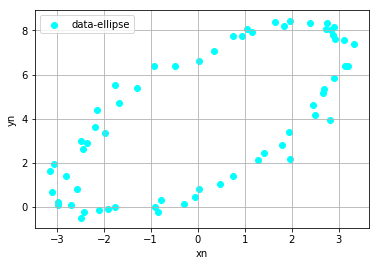

Text(0, 0.5, 'yn')

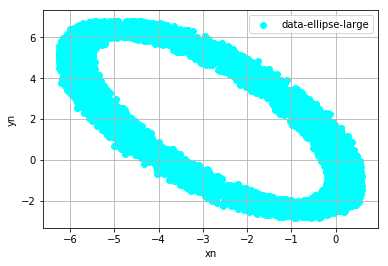

In [4]:
#plt.figure(figsize=[10,7])
plt.scatter(data['xn'],data['yn'],color='cyan',label='data-ellipse')
plt.grid()
plt.legend()
plt.xlabel('xn')
plt.ylabel('yn')
plt.show()
plt.scatter(data_large['xn'],data_large['yn'],color='cyan',label='data-ellipse-large')
plt.grid()
plt.legend()
plt.xlabel('xn')
plt.ylabel('yn')

### Three main methods were implemented

**1.  Naive method where normalized fit for the ellipse was found using $x=A^{-1}b$ by incorporating SVD for A**

**2.  Using SVD and taking into consideration the fact that the eigen vector corresponding to the minimum of eigen value forms the solution in homogenous system of equations i.e., $UDV^T x = 0$ has solution as $V[index(min(D))]$**

**3.  Using EVD to find the solution where $x=V[index(max(eigen\_value([A^T A]^{-1}C)))]$ where $C$ in the constraint matrix**

While plotting the contour, levels=0 is taken as it represents f(x,y)=levels=0 for our case where f(x,y) is the quadratic representing ellipse.

In [5]:
def my_naive(df,title):
    y=df['yn']
    x=df['xn']
    
    ##Normalizing
    ##Converting to zero mean and standard deviation=1
    xmean=x.mean()
    xstd=x.std()
    ymean=y.mean()
    ystd=y.std()
    x=(x-xmean)/xstd
    y=(y-ymean)/ystd
    
    #Creating design matrix A
    one=np.ones(len(x))
    one=-1*one
    A=[]
    A.append(x*x)
    A.append(x*y)
    A.append(y*y)
    A.append(x)
    A.append(y)
    A=np.transpose(A)
    A=np.matrix(A)
    
    #Computing SVD then using traditional method of inverse
    u,s,vT = np.linalg.svd(A)
    index=np.argmin(s)
    
    S = np.matrix(np.zeros((u[0].shape[1], len(vT))))
    
    S=S.T
    np.fill_diagonal(S,1/s) #finding inverse of the diagonal matrix
    
    # u*diag(s)*vT*x = b so now multiplying by u^-1 we get diag(s)*vT*x = u.T*b =temp
    # Now multiplying both sides by inverse of s we get vT*x = S*temp = temp2 
    # Finally multiply both sides by vT^-1 = v we get xfinal=v*temp2
    b=one.T
    x_final = np.dot(np.dot(np.linalg.inv(vT),np.dot(S,np.linalg.inv(u))),b)
    
    
    #We need to plot the contour as not every single x element will have a correspoinding y element
    xx = np.linspace(np.min(x),np.max(x))
    yy = np.linspace(np.min(y),np.max(y))
    xx,yy = np.meshgrid(xx,yy)
    
    #Finding the index of V corresponding to least rmse 
    mn=np.inf
    xidx=0
    
    for i in range(len(vT.T)):
        vv=np.array(vT.T[i])[0]
        temp=np.sum((vv[0]*x*x + vv[1]*x*y + vv[2]*y*y + vv[3]*x + vv[4]*y + 1)**2)
        temp=np.sqrt(temp/len(x))
        if mn>temp:
            mn=temp
            xidx=i
    
    vv=np.array(x_final)[0]
    mn=np.sqrt(np.sum((vv[0]*x*x + vv[1]*x*y + vv[2]*y*y + vv[3]*x + vv[4]*y+1)**2)/len(x))
    Y=(vv[0]*xx*xx + vv[1]*xx*yy + vv[2]*yy*yy + vv[3]*xx + vv[4]*yy+1)
    print('RMSE Naive ',title,': ',mn)
    
    plt.scatter(x,y,color='cyan',label='Original')
    plt.contour(xx,yy,Y,levels=[0],colors='k')
    
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Naive: '+str(title))
    plt.grid()
    plt.show()


In [6]:
def my_svd(df,title,z):
    y=df['yn']
    x=df['xn']
    
    
    #Creating design matrix A
    one=np.ones(len(x))
    A=[]
    A.append(x*x)
    A.append(x*y)
    A.append(y*y)
    A.append(x)
    A.append(y)
    A.append(one)
    A=np.transpose(A)
    A=np.matrix(A)
    
    
    
    #Computing SVD 
    u,s,vT = np.linalg.svd(A)
    
    #Finding the index of least eigen value to get the corresponding eigen vector
    index=np.argmin(s)#  = last eigen value as the eigen values in s are in decreasing order 
    x_final=(vT.T[:,index]).T#= vT[-1,:]
    
    #We need to plot the contour as not every single x element will have a correspoinding y element
    xx = np.linspace(np.min(x),np.max(x))
    yy = np.linspace(np.min(y),np.max(y))
    xx,yy = np.meshgrid(xx,yy)
    
    
    Y=x_final[0,0]*xx*xx + x_final[0,1]*xx*yy + x_final[0,2]*yy*yy + x_final[0,3]*xx + x_final[0,4]*yy + x_final[0,5]
    mn=np.sqrt(np.sum((x_final[0,0]*x*x + x_final[0,1]*x*y + x_final[0,2]*y*y + x_final[0,3]*x + \
                       x_final[0,4]*y + x_final[0,5])**2)/len(x))
    if z==True:
        print('RMSE SVD ',title,': ',mn)
    plt.scatter(x,y,color='cyan',label='Original')
    plt.contour(xx,yy,Y,levels=0,colors='k')
    
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('SVD: '+str(title))
    plt.grid()
    plt.show()
    

    

In [7]:
def my_eigen(df,title,z):
    y=df['yn']
    x=df['xn']
    one=np.ones(len(x))
    A=[]
    A.append(x*x)
    A.append(x*y)
    A.append(y*y)
    A.append(x)
    A.append(y)
    A.append(one)
    A=np.transpose(A)
    A=np.matrix(A)
    
    
    #Setting up the condition matrix
    C = np.zeros([6,6])
    C[0,2] = 2
    C[2,0] = 2
    C[1,1] = -1
    
    #Inverse of Scatter matrix
    Anew=np.linalg.inv(np.dot(A.transpose(),A))
    
    #Getting eigen values in temp1 and eigen vectors in v
    temp1,v= np.linalg.eig(np.dot(Anew,C))
    
    #Finding the index of maximum eigen value
    idx=np.argmax(abs(temp1))
    #Choosing the corresponding eigen vector
    
    vv=np.array(v.T[idx])[0]
    
    
    mn=np.inf
    xx = np.linspace(np.min(x),np.max(x))
    yy = np.linspace(np.min(y),np.max(y))
    xx,yy = np.meshgrid(xx,yy)
    Y=(vv[0]*xx*xx + vv[1]*xx*yy + vv[2]*yy*yy + vv[3]*xx + vv[4]*yy + vv[5])
    if (vv[1]**2 - 4*vv[0]*vv[2])>0:
        print('Condition not satisfied')
    
    #Verifying that the least RMSE is obtained for the same eigen vector as that obtained by taking maximum eigen value
    for i in range(len(v)):
        vv=np.array(v.T[i])[0]
        temp=np.sum((vv[0]*x*x + vv[1]*x*y + vv[2]*y*y + vv[3]*x + vv[4]*y + vv[5])**2)
        if(temp>0):
            temp=np.sqrt(temp/len(x))
            if mn>temp:
                mn=temp
                vfinal=i
    if z==True:
        print('RMSE EVD ',title,': ',mn)

    plt.contour(xx,yy,Y,levels=0,colors='k')
    plt.scatter(x,y,color='cyan')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('EVD: '+str(title))
    plt.grid()
    plt.show()
    
    

### Naive approach

RMSE Naive  ellipse-data :  0.15472622294014263


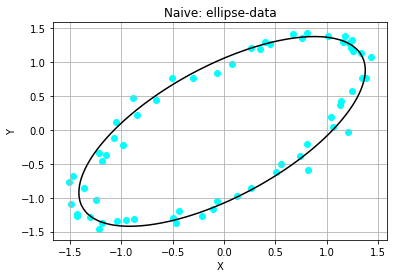

RMSE Naive  ellipse-data-large :  0.16918298771861648


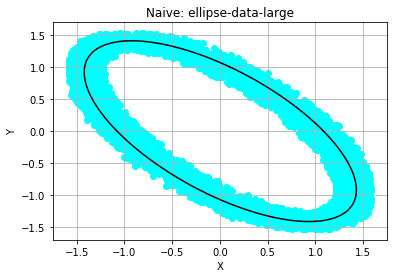

In [8]:
my_naive(data,'ellipse-data')    
my_naive(data_large,'ellipse-data-large')   


In [9]:
def get_normalised(df):
    xmean=df['xn'].mean()
    ymean=df['yn'].mean()
    xstd=df['xn'].std()
    ystd=df['yn'].std()
    xx=(df['xn']-xmean)/xstd
    yy=(df['yn']-ymean)/ystd
    frame={'xn':xx,'yn':yy}
    temp=pd.DataFrame(frame)
    return temp

In [10]:
#for normalized version
data_temp=get_normalised(data)
data_large_temp=get_normalised(data_large)

### Q2. SVD and RMSE for both the cases

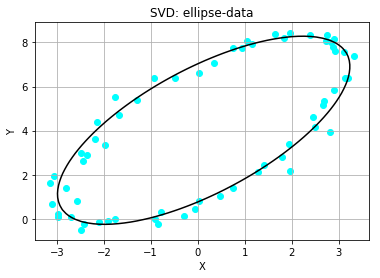

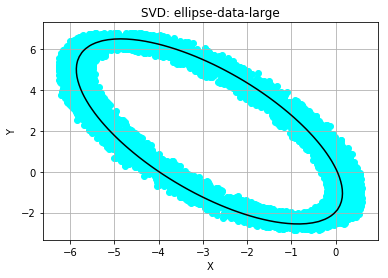

RMSE SVD  ellipse-data-normalised :  0.07718992052158492


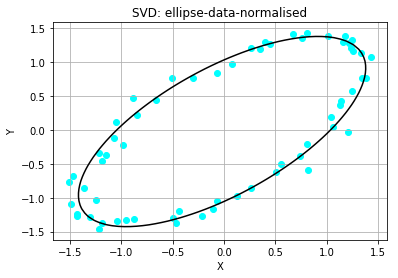

RMSE SVD  ellipse-data-large-normalised :  0.08514567847620477


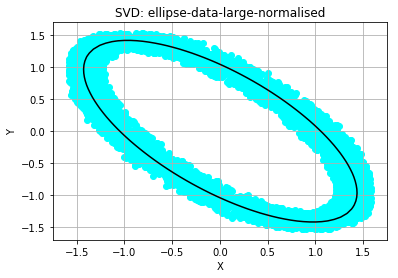

In [11]:
my_svd(data,'ellipse-data',False)    
my_svd(data_large,'ellipse-data-large',False)   
my_svd(data_temp,'ellipse-data-normalised',True)    
my_svd(data_large_temp,'ellipse-data-large-normalised',True)   




### Q3. EVD along with constraints and RMSE for both the cases

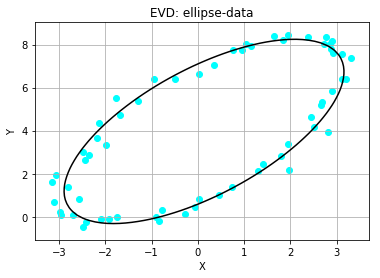

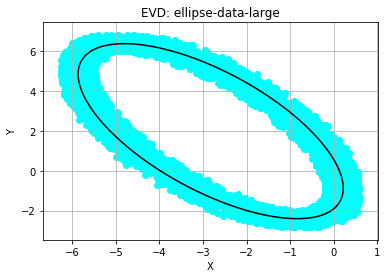

RMSE EVD  ellipse-data-normalised :  0.07832454807813741


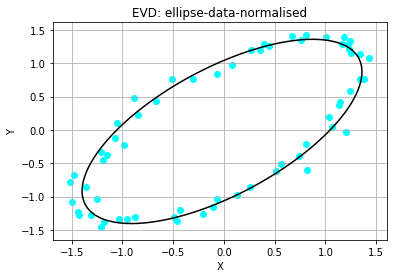

RMSE EVD  ellipse-data-large-normalised :  0.08672625207497954


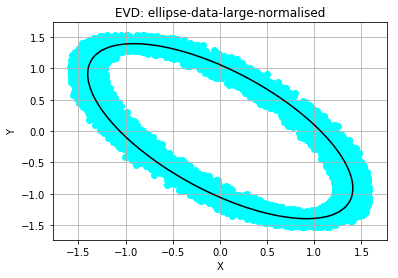

In [12]:
my_eigen(data,'ellipse-data',False)  
my_eigen(data_large,'ellipse-data-large',False)   
my_eigen(data_temp,'ellipse-data-normalised',True)    
my_eigen(data_large_temp,'ellipse-data-large-normalised',True)   

**We can see from the RMSE calculated for each case with normalized data-points that SVD method of least eigen value gives better result than the naive method of computing the inverse and solving $A^{-1}b$.**

**We notice that we could get the correct fit for the actual ellipse just like the normalised case. RMSE calculation for normalised data was convinient due to the simplicity arising from zero mean and 1 standard deviation. The effect of normalisation does not take away the key-features of the ellipse so this step of calculating rmse of normalised ellipse fit is valid.**


**We can also notice that SVD has low RMSE for both the cases as compared to EVD.**